# このノートでやった（できる）こと
### scikit-lernのneural networkを用いて、目的変数の確率を算出し、算出した値を元に様々な掛け方をした場合の回収率を計算

#### 計算に用いた特徴量
- 各レーサーのクラス
- 各レーサーの各枠における平均スタートタイム
- 各レーサーの連帯率
- 展示タイム

#### 目的変数
- 1枠: 1着になる (1) or ならない (0)
- 2-6枠: 3着以内にはいる (1) or 入らない (0)


### 結果
#### Regression結果
- logistic regressionと比べてうまく行かない？（スコアが高い部分で的中率が高く、相関は見られるが0.5, 0.6くらいのスコアが多く出てしまう）
#### bet結果


In [4]:
# 必要なモジュールのインポート

from sklearn.neural_network import MLPClassifier
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle

import sys
import os

current_dir = os.getcwd()
sys.path.append(os.path.join(current_dir, '../conf/'))
sys.path.append(os.path.join(current_dir, '../crawl/'))
sys.path.append(os.path.join(current_dir, '../data_preparing/'))
sys.path.append(os.path.join(current_dir, 'analyzer_conf/'))

# my module
import loader
import boatrace_crawler_conf
import analyzer_conf

In [5]:
# 過去のレース結果をdfとして取得
the_merged_df = loader.make_merged_df()
# dfをソート
the_merged_df = the_merged_df.sort_values(["date", "venue", "raceNumber"])
# print(the_merged_df["exhibitionTime_1"])

In [6]:
# logistic regressionを利用した学習

def make_df_for_analyze(merged_df, fv_list, column_list_label, odds_list):
    """
    parameters
        fv_list: dfのうち、特徴量として用いるカラム名のリスト
        column_list_label: dfのうち、labelとして用いるカラム名のリスト
    """
    
    # ラベルの数を変数名にしておく。labelと特徴量を分けるときに使う
    num_labels = len(column_list_label)

    # 解析用dfを作成
    fv_label_odds_df = the_merged_df[fv_list + column_list_label + odds_list]
    
    # nanを含む行を削除
    fv_label_odds_df = fv_label_odds_df.dropna()
    
    # oddsはないバージョンのdf
    fv_label_df = fv_label_odds_df[fv_list + column_list_label ]
    
    # クラスカラムを，A1 =0, A2 = 1のように数字に変換する
    class_dict = {"A1": 0, "A2":1, "B1": 2, "B2": 3}
    for key, value in class_dict.items():
        fv_label_df.replace(key, value, inplace = True)

    # なぜかdtypeがstrになっちゃうのでintに戻す
    fv_labe_df = fv_label_df.astype(float)

    # ラベルをbooleanに変換
    fv_label_df = analyzer_conf.make_label_boolean_ver1(
        fv_label_df, column_list_label)
    print("解析用dfの行数は.{0}".format(len(fv_label_df)))
    
    """
    # 特徴量を標準化
    fv_label_df = analyzer_conf.standerdize_feature_values(
        fv_label_df, column_list_label)
    """        
    return fv_label_df, fv_label_odds_df


def separate_train_test_dataset(for_analysis_df, train_data_ratio):
       
    # 解析用df（特徴量+label）を、学習用データとテストデータのarrayに分ける
    train_size = int(len(for_analysis_df) * train_data_ratio)
    train_data = for_analysis_df[:train_size].values
    test_data = for_analysis_df[train_size:].values
    
    return train_data, test_data, train_size

    
def learn_logistic_regression(train_data, column_list_label):
    
    """
    1枠が1着になるかどうか？2枠以降に関しては3着以内に入るかどうか？を scikit-lernのlogistic regressionを用いて学習する。
    複数のラベルをリストとして入力することが可能で、戻り値はそれぞれのlabelに対して学習を行なった結果のモデルを各要素にもつリスト
    
    return
        clf_list: 各ラベルについて学習したモデルのlist
    
    TODO
        ラベルの作成方法などもinput parameterとして指定できた方がいい。
        むしろregressionの方法もinputにして超汎用的な関数を外側に作るか？
    
    """
    # ラベルとしてもちいる部分の数。labelと特徴量を分ける際に使用、
    num_labels = len(column_list_label)
    
    # 特徴量部分のarray
    train_x = train_data[:, :-num_labels]

    # ロジスティック回帰を行なった結果得られるオブジェクトをリストに格納
    clf_list  = []

    for i, column_label in enumerate(column_list_label):
        # ラベルを指定
        train_t = train_data[:, - num_labels + i]

        # ロジスティック回帰
        clf = MLPClassifier(hidden_layer_sizes=(24, 24), max_iter=10000)
        clf.fit(train_x, train_t)

        clf_list.append(clf)
    
    return clf_list, num_labels


# ----------input-------------
# 解析に使う特徴量カラム
fv_list = []
for i in range(1, 7):
    # 各枠のレーサーのクラス
    fv_list.append("class_{0}".format(i))
    # 各枠の平均ST
    fv_list.append("aveST_frame{0}".format(i))
    # 連帯率
    fv_list.append("placeRate_frame{0}".format(i))
    # 展示タイム
    fv_list.append("exhibitionTime_{0}".format(i))

# 解析に使うラベルカラム: 今回は一枠が一着になるかどうか？を予測
column_list_label = ["rank_{0}".format(i) for i in range(1,7)]

# 回収率計算に使用するオッズラベルのリスト
odds_list =  ["win", "winOdds", 
             "place_1", "placeOdds_1",
             "place_2", "placeOdds_2",
             "exacta", "exactaOdds",
             "quinella", "quinellaOdds",
             "wide_1", "wideOdds_1", 
             "wide_2", "wideOdds_2",
             "wide_3", "wideOdds_3",
             "trifecta", "trifectaOdds",
             "trio", "trioOdds"]

# データのうち、教師データとして使う割合（残りをテストデータとして用いる）
train_data_ratio = 0.7

# --------------------------------

# main

fv_label_df, fv_label_odds_df = make_df_for_analyze(the_merged_df, fv_list, column_list_label, odds_list)
train_data, test_data, train_size = separate_train_test_dataset(fv_label_df, train_data_ratio)
clf_list, num_labels = learn_logistic_regression(train_data, column_list_label)

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3798: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)
/usr/local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


解析用dfの行数は.26325


1号艇についてtrainデータを使った正解率は0.5322624409833396,
           testデータを使った正解率は0.5200050645733097
2号艇についてtrainデータを使った正解率は0.6250610517175883,
           testデータを使った正解率は0.6107875411496582
3号艇についてtrainデータを使った正解率は0.6059586476366202,
           testデータを使った正解率は0.5987591795391238
4号艇についてtrainデータを使った正解率は0.6241927606229989,
           testデータを使った正解率は0.6095213978222335
5号艇についてtrainデータを使った正解率は0.5571715417593748,
           testデータを使った正解率は0.539883514813877
6号艇についてtrainデータを使った正解率は0.7222553861181962,
           testデータを使った正解率は0.7229678399594834


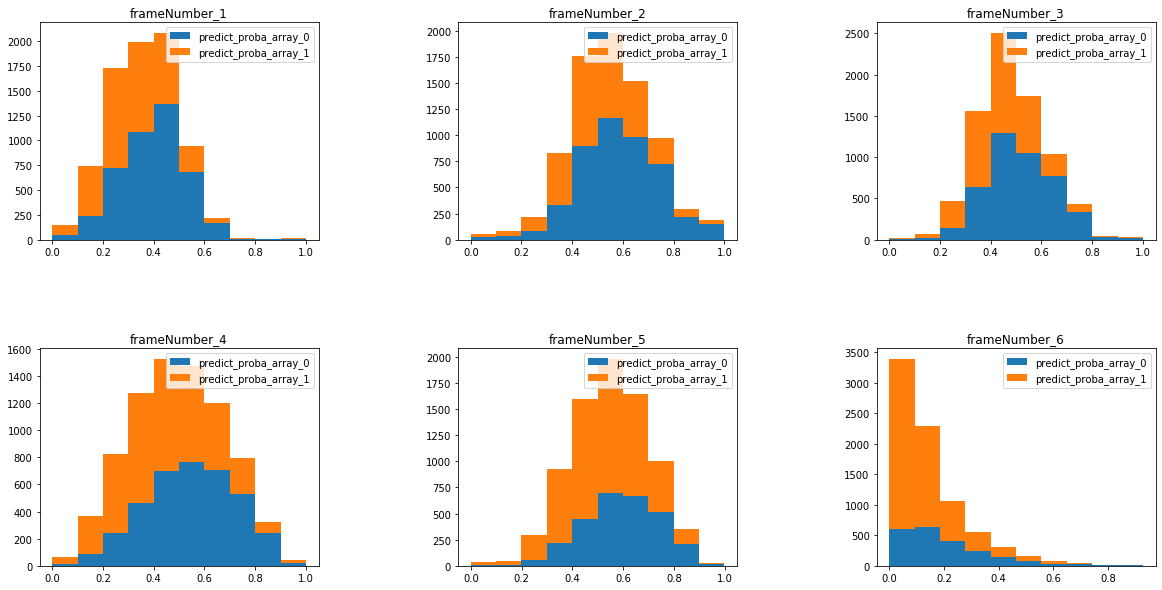

In [10]:
"""
上のセルで学習したclfを用いて色々と解析する。
今このセルで行なっている解析は
1. 各labelについて正解率を計算
2. 最適化された結果の切片および各係数を表示
3. テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成

"""
# 描画用の枠を用意

plt.figure(figsize=(20, 10))
plt.subplots_adjust(wspace=0.5,hspace=0.5)

# 回収率計算用に、[predict_proba_array, test_t]を各要素にもつリストを作成
predict_proba_array_list = []

# 正解率の計算などのため、train data, test dataそれぞれについて、特徴量部分のarrayとlabel部分のarrayを作成
train_x = train_data[:, :-num_labels]
test_x = test_data[:, :-num_labels]

for i, clf in enumerate(clf_list):
    train_t = train_data[:, - num_labels + i]
    test_t = test_data[:, - num_labels + i]
    
    # 正解率を計算
    train_score = clf.score(train_x, train_t)
    test_score = clf.score(test_x, test_t)
    print("{2}号艇についてtrainデータを使った正解率は{0},\n \
          testデータを使った正解率は{1}".format(train_score, test_score, i + 1))

    # テストデータについて、学習結果を適用した際に、ラベルが1になる確率を、実際のラベル　1 or　0で色分けしてヒストグラムを作成
    predict_proba_array = clf.predict_proba(test_x)
    
    # listに格納しておく
    predict_proba_array_list.append(predict_proba_array[:, 1])

    # 結果が1 (1枠が一着 , 2枠以降が3着以内) だったものの推定確率
    predict_proba_array_1 = predict_proba_array[:, 1][test_t==1]

    # 結果が0 (1枠以外が一着, 1枠以外の場合は4着以降) だったものの推定確率
    predict_proba_array_0 = predict_proba_array[:, 1][test_t==0]

    # 積み上げヒストグラムを作成
    title = "frameNumber_{0}".format(i + 1)
    labels = {'predict_proba_array_1', 'predict_proba_array_0'}
    plt.subplot(2, 3, i+1)
    plt.hist([predict_proba_array_1, predict_proba_array_0], histtype="barstacked", label=labels)
    plt.title(title)
    plt.legend()
plt.show()

# 考察
- 正解率はいずれのラベルに対しても6割から7割程度にとどまるが、test dataとtraining dataで同程度の正解率をだす。
確率ごとにプロットをしてみると、
- predict_probaが小さい時は実際に0ラベル、predict_probaが大きい時は実際に1ラベルであることがかなり多くなっている。
- 正解率を下げているのは実際に判断が難しいところ（0.3 < predict_proba < 0.7くらいの場所） であり、predict_probaが高いところ、低いところを抽出して用いることで十分に予測器として使用可能
- 1着以外が1位になる，荒れるレースの予測や、1着を1枠に固定し、2, 3を高いprobabilityを示すものでbox買するといったオプションが考えられる。

そこで、以下のセルにおいては掛け方を色々してみた時の回収率計算を行う。

In [5]:
# 計算用dfを作成
# 6列目までが上の解析によって求めた確率(1号艇が1位になる率, 2-6号艇が3位以内に入る確率)
# 7列目以降にオッズ関係の値を格納

for_calc_refund_rate_df = pd.DataFrame(np.vstack(predict_proba_array_list).T, columns=["PredProb_{0}".format(i) for i in range(1, 7)])
for odds_column_name in odds_list:
    # TODO intで入れられるものはintで。無理なものはとりあえずobjectのままで格納
    for_calc_refund_rate_df[odds_column_name] = fv_label_odds_df[odds_column_name][train_size:].values

print(for_calc_refund_rate_df)

      PredProb_1  PredProb_2  PredProb_3  PredProb_4  PredProb_5  PredProb_6  \
0       0.745875    0.587754    0.383519    0.310229    0.555342    0.220354   
1       0.433385    0.706442    0.446340    0.488409    0.455447    0.185633   
2       0.341985    0.525627    0.615446    0.679780    0.331560    0.233195   
3       0.602672    0.699038    0.268890    0.477819    0.603503    0.131276   
4       0.628892    0.591280    0.461068    0.475035    0.380044    0.319001   
5       0.644511    0.603653    0.557553    0.527356    0.269021    0.267946   
6       0.596226    0.563994    0.556024    0.446829    0.380723    0.328295   
7       0.644296    0.503406    0.498746    0.617244    0.292519    0.267969   
8       0.564643    0.524634    0.497880    0.549442    0.360610    0.306451   
9       0.571067    0.490343    0.561790    0.417889    0.495208    0.254562   
10      0.578308    0.524043    0.541653    0.555141    0.348054    0.264840   
11      0.695461    0.529922    0.635840

In [18]:
# 確率x_1以上のときのみ、1に単勝賭けした時の回収率
x_1_list = [0.6, 0.7, 0.8]
for x_1 in x_1_list:
    bet = sum(for_calc_refund_rate_df["PredProb_1"] > x_1)

    return_boolean = (for_calc_refund_rate_df["PredProb_1"] > x_1) & (for_calc_refund_rate_df["win"] == "1")
    return_ = sum(for_calc_refund_rate_df["winOdds"][return_boolean])

    print("確率{0}以上で1に単勝betした場合、的中率は{1}".format(x_1, sum(return_boolean) / bet))
    print("確率{0}以上で1に単勝betした場合, 回収率は{1}".format(x_1, return_ / (bet * 100)))

確率0.6以上で1に単勝betした場合、的中率は0.6932569413838695
確率0.6以上で1に単勝betした場合, 回収率は0.9071397091229616
確率0.7以上で1に単勝betした場合、的中率は0.7420901246404602
確率0.7以上で1に単勝betした場合, 回収率は0.9070949185043145
確率0.8以上で1に単勝betした場合、的中率は0.8153846153846154
確率0.8以上で1に単勝betした場合, 回収率は0.94


In [19]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率がx_2超えがあった場合に、1-XY..の形で2連単bet

x_1_list = [0.7, 0.75, 0.8]
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0

        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        bet_num = "1-{0}".format(j)
                        bet = bet + 100
                        if row["exacta"] == bet_num:
                            income = income + row["exactaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で2連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.7以上かつ、p2-6が0.5以上で2連単betすると収益は-34660, 回収率は0.8084024322830293
p1が0.7以上かつ、p2-6が0.6以上で2連単betすると収益は-19210, 回収率は0.801958762886598
p1が0.7以上かつ、p2-6が0.7以上で2連単betすると収益は-6860, 回収率は0.8175531914893617
p1が0.7以上かつ、p2-6が0.8以上で2連単betすると収益は-2860, 回収率は0.6425
p1が0.75以上かつ、p2-6が0.5以上で2連単betすると収益は-12590, 回収率は0.8347769028871391
p1が0.75以上かつ、p2-6が0.6以上で2連単betすると収益は-6650, 回収率は0.8333333333333334
p1が0.75以上かつ、p2-6が0.7以上で2連単betすると収益は-1440, 回収率は0.9058823529411765
p1が0.75以上かつ、p2-6が0.8以上で2連単betすると収益は-800, 回収率は0.7714285714285715
p1が0.8以上かつ、p2-6が0.5以上で2連単betすると収益は-510, 回収率は0.973015873015873
p1が0.8以上かつ、p2-6が0.6以上で2連単betすると収益は-500, 回収率は0.9411764705882353
p1が0.8以上かつ、p2-6が0.7以上で2連単betすると収益は-550, 回収率は0.78
p1が0.8以上かつ、p2-6が0.8以上で2連単betすると収益は260, 回収率は1.3714285714285714


In [9]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2超えがあった場合に、1-X-9と1-9-Xの形で3連単bet
x_1_list = [0.6, 0.7, 0.8]
x_2_list = [0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j:
                                bet = bet + 200
                                bet_num_1 = "1-{0}-{1}".format(j, k)
                                bet_num_2 = "1-{0}-{1}".format(k, j)
                                # print(bet_num_1, bet_num_2, row["trifecta"], row["trifectaOdds"])
                                if row["trifecta"] == bet_num_1 or row["trifecta"] == bet_num_2:
                                    income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-397260, 回収率は0.7704230235783633
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-200740, 回収率は0.7119115958668197
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-51410, 回収率は0.692523923444976
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-140220, 回収率は0.8216937945066124
p1が0.7以上かつ、p2-6が0.7以上で3連単betすると収益は-69100, 回収率は0.7690508021390374
p1が0.7以上かつ、p2-6が0.8以上で3連単betすると収益は-23280, 回収率は0.6535714285714286
p1が0.8以上かつ、p2-6が0.6以上で3連単betすると収益は-20360, 回収率は0.7172222222222222
p1が0.8以上かつ、p2-6が0.7以上で3連単betすると収益は-10420, 回収率は0.479
p1が0.8以上かつ、p2-6が0.8以上で3連単betすると収益は-2180, 回収率は0.659375


In [8]:
# 上と同じノリで2着固定。すなわち、
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2超えがあった場合に、1-X-9の形で3連単bet
x_1_list = [0.5, 0.6, 0.7, 0.8]
x_2_list = [0.4, 0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        for k in range(2, 7):
                            if k is not j:
                                bet = bet + 100
                                bet_num = "1-{0}-{1}".format(j, k)
                                if row["trifecta"] == bet_num:
                                    income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.5以上かつ、p2-6が0.4以上で3連単betすると収益は-915830, 回収率は0.7479829389102917
p1が0.5以上かつ、p2-6が0.5以上で3連単betすると収益は-570730, 回収率は0.7675802247923115
p1が0.5以上かつ、p2-6が0.6以上で3連単betすると収益は-356050, 回収率は0.7313235738001811
p1が0.5以上かつ、p2-6が0.7以上で3連単betすると収益は-139060, 回収率は0.7522095509622239
p1が0.5以上かつ、p2-6が0.8以上で3連単betすると収益は-41480, 回収率は0.7347826086956522
p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-618190, 回収率は0.7466019019511395
p1が0.6以上かつ、p2-6が0.5以上で3連単betすると収益は-383840, 回収率は0.7647462613385634
p1が0.6以上かつ、p2-6が0.6以上で3連単betすると収益は-233830, 回収率は0.7297387887193713
p1が0.6以上かつ、p2-6が0.7以上で3連単betすると収益は-96200, 回収率は0.7238805970149254
p1が0.6以上かつ、p2-6が0.8以上で3連単betすると収益は-27890, 回収率は0.6663875598086124
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-316190, 回収率は0.7095977222630419
p1が0.7以上かつ、p2-6が0.5以上で3連単betすると収益は-205070, 回収率は0.7180005500550055
p1が0.7以上かつ、p2-6が0.6以上で3連単betすると収益は-108080, 回収率は0.7251271617497457
p1が0.7以上かつ、p2-6が0.7以上で3連単betすると収益は-35670, 回収率は0.7615641711229947
p1が0.7以上かつ、p2-6が0.8以上で3連単betすると収益は-16670, 回収率は0.5038690476190476
p1が0.8以上かつ、p2-6

In [7]:
# 1号艇の勝率x_1以上の時、他の艇で3位以内率x_2以下が2艇以上あった場合に、1頭で、2割以下艇を外した残りを2, 3着boxにして買う
x_1_list = [0.6, 0.7, 0.8]
x_2_list = [0.4, 0.3, 0.2]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        
        income = 0
        bet = 0
        
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] > x_1):
                outers = (row[["PredProb_{0}".format(n) for n in range(2, 7)]] < x_2)
                num_outers = sum(outers)
                if (num_outers > 1):
                    for j in range(2, 7):
                        if row["PredProb_{0}".format(j)] > x_2:
                            for k in range(2, 7):
                                if k is not j and row["PredProb_{0}".format(k)] > x_2:
                                    bet = bet + 100
                                    bet_num = "1-{0}-{1}".format(j, k)
                                    if row["trifecta"] == bet_num:
                                        income = income + row["trifectaOdds"]
        print("p1が{0}以上かつ、p2-6が{1}以上で3連単betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.6以上かつ、p2-6が0.4以上で3連単betすると収益は-115110, 回収率は0.8752059843885516
p1が0.6以上かつ、p2-6が0.3以上で3連単betすると収益は-99070, 回収率は0.808671301660873
p1が0.6以上かつ、p2-6が0.2以上で3連単betすると収益は-12760, 回収率は0.768840579710145
p1が0.7以上かつ、p2-6が0.4以上で3連単betすると収益は-63360, 回収率は0.8452369320957499
p1が0.7以上かつ、p2-6が0.3以上で3連単betすると収益は-38040, 回収率は0.8655830388692579
p1が0.7以上かつ、p2-6が0.2以上で3連単betすると収益は-9080, 回収率は0.656060606060606
p1が0.8以上かつ、p2-6が0.4以上で3連単betすると収益は2280, 回収率は1.0471074380165288
p1が0.8以上かつ、p2-6が0.3以上で3連単betすると収益は-8860, 回収率は0.7394117647058823
p1が0.8以上かつ、p2-6が0.2以上で3連単betすると収益は-3080, 回収率は0.14444444444444443


In [64]:
# 1の確率がx_1以下のとき、2-6号艇の値がx_2以上のものに対して単勝bet
x_1_list = [0.2, 0.3, 0.4, 0.5]
x_2_list = [0.5, 0.6, 0.7, 0.8]

for x_1 in x_1_list:
    for x_2 in x_2_list:
        income = 0
        bet = 0
        for index, row in for_calc_refund_rate_df.iterrows():
            if (row["PredProb_1"] < x_1):
                for j in range(2, 7):
                    if row["PredProb_{0}".format(j)] > x_2:
                        bet_num = "{0}".format(j)
                        bet = bet + 100
                        if row["win"] == bet_num:
                            income = income + row["winOdds"]
        print("p1が{0}以下のとき、p2-6が{1}以上なら単勝betすると収益は{2}, 回収率は{3}".format(x_1, x_2, income-bet, income/bet))

p1が0.2以下のとき、p2-6が0.5以上なら単勝betすると収益は-1290, 回収率は0.9593059936908518
p1が0.2以下のとき、p2-6が0.6以上なら単勝betすると収益は-220, 回収率は0.9903083700440528
p1が0.2以下のとき、p2-6が0.7以上なら単勝betすると収益は-410, 回収率は0.9661157024793389
p1が0.2以下のとき、p2-6が0.8以上なら単勝betすると収益は720, 回収率は1.1263157894736842
p1が0.3以下のとき、p2-6が0.5以上なら単勝betすると収益は-13470, 回収率は0.9048728813559322
p1が0.3以下のとき、p2-6が0.6以上なら単勝betすると収益は-11600, 回収率は0.8836509528585758
p1が0.3以下のとき、p2-6が0.7以上なら単勝betすると収益は-3860, 回収率は0.9308243727598566
p1が0.3以下のとき、p2-6が0.8以上なら単勝betすると収益は-1710, 回収率は0.9113989637305699
p1が0.4以下のとき、p2-6が0.5以上なら単勝betすると収益は-50650, 回収率は0.8614984960350014
p1が0.4以下のとき、p2-6が0.6以上なら単勝betすると収益は-29750, 回収率は0.8803298471440064
p1が0.4以下のとき、p2-6が0.7以上なら単勝betすると収益は-6700, 回収率は0.9495101733232856
p1が0.4以下のとき、p2-6が0.8以上なら単勝betすると収益は-3390, 回収率は0.9254945054945055
p1が0.5以下のとき、p2-6が0.5以上なら単勝betすると収益は-94830, 回収率は0.8376198630136986
p1が0.5以下のとき、p2-6が0.6以上なら単勝betすると収益は-57100, 回収率は0.8514568158168574
p1が0.5以下のとき、p2-6が0.7以上なら単勝betすると収益は-18970, 回収率は0.9058093346573982
p1が0.5以下のとき、p2-6が0.8以上